# Image Classification using Convolutional Neural Networks in PyTorch

Install requirements libraries<br>
but on Colab they already have.

  * Google Colab [Image Classification using CNNs | Deep Learning with PyTorch (4/6)](https://colab.research.google.com/drive/1xYVrRfIHYiEm-15wdqg3QaaswwCX3k3m?usp=sharing)

  * Jovian [Part 5 of "Deep Learning with Pytorch: Zero to GANs"](https://jovian.com/aakashns/05-cifar10-cnn#C93)

In [66]:
#!pip3 install matplotlib torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [67]:
# Import libraries
import os, tarfile
import torch, torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

### Download image in PNG format

In [68]:
# # Uncomment this code to download the dataset

# # Download the dataset
# dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url, ".")

# # Extract from archive
# with tarfile.open("cifar10.tgz", mode="r:gz") as tar:
#   tar.extractall(path="./data")

The data is extracted to the directory `data/cifar10`, it contains 2 folder `train/test` 

In [69]:
data_dir = "./data/cifar10"

print("Inside folder cifar10: \n", os.listdir(data_dir))

classes = os.listdir(data_dir + "/train")
print("Classes name: \n", classes)

Inside folder cifar10: 
 ['test', 'train']
Classes name: 
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Load dataset

We can use the `ImageFolder` class from `torchvision` to load the data as Pytorch tensors.

In [70]:
# Import libraries
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams["figure.facecolor"] = "#ffffff"

`dataset` variable consist of a tuple containing a image tensor (`torch.Size([3, 32, 32])`) and a label

The list of classes name is stored in `.classes` property of dataset.
The numeric label for each element relate to index of the element's label in the list of classes.

In [71]:
# ToTensor() → Convert a PIL Image or ndarray to tensor and scale the values accordingly.
dataset = ImageFolder(root = data_dir + "/train", transform=ToTensor()) # 
print(len(dataset))
print(dataset.classes)

# print image shape and label
img, label = dataset[0]
print(img.shape, dataset.classes[label])

50000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([3, 32, 32]) airplane


In [72]:
print(type(img))
img

<class 'torch.Tensor'>


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

### Plot the image dataset

We can view the image by using `matplotlib`, but we need to change the tensor dimensions to `(32, 32, 3)`

The img parameter is a PyTorch tensor and uses permute`(1, 2, 0)` to change the order of dimensions from `(C, H, W)` to `(H, W, C)` so that it can be displayed correctly by imshow.

In [73]:
def show_example(img, label):
  print("Label", dataset.classes[label], "("+str(label) + ")")
  plt.imshow(img.permute(1, 2, 0))

Label airplane (0)


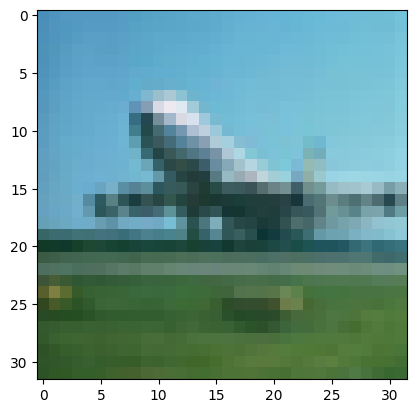

In [74]:
img, label = dataset[100]
show_example(img, label)

Label airplane (0)


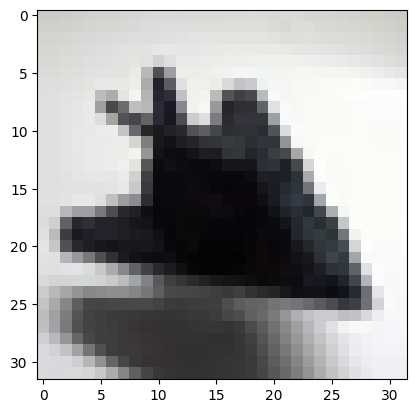

In [75]:
show_example(*dataset[0])

Label airplane (0)


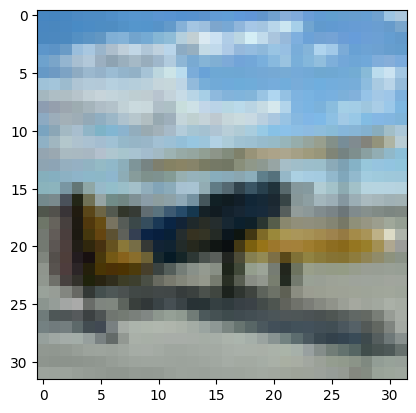

In [76]:
show_example(*dataset[1009])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 part:
  1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
  2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc,) and pick the best version of the model.
  3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

  We will create `validation dataset` for a small portion from the training set, we'll use the `random_split` helper method from PyTorch to do this.  

In [77]:
random_seed = 40 # Can be any number
torch.manual_seed(random_seed)

In [78]:
val_size = 4000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print(len(train_ds), len(val_ds))

46000 4000


Create data loaders from training and validation, to load the data in batches

In [79]:
from torch.utils.data.dataloader import DataLoader
batch_size = 64

In [80]:
train_dl = DataLoader(dataset = train_ds,
                      batch_size = batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(dataset = val_ds,
                    batch_size = batch_size * 2,
                    num_workers=4,
                    pin_memory=True)

### Plot all batch image

Using `make_grid` method from `torchvision` to display images from batches. Each time the following code is rud, we get a different batch.

In [81]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

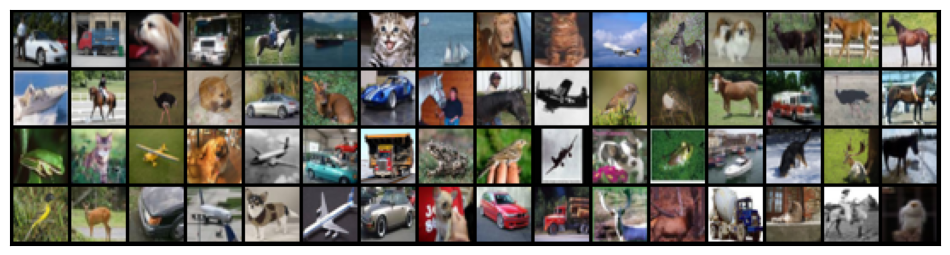

In [82]:
show_batch(train_dl)

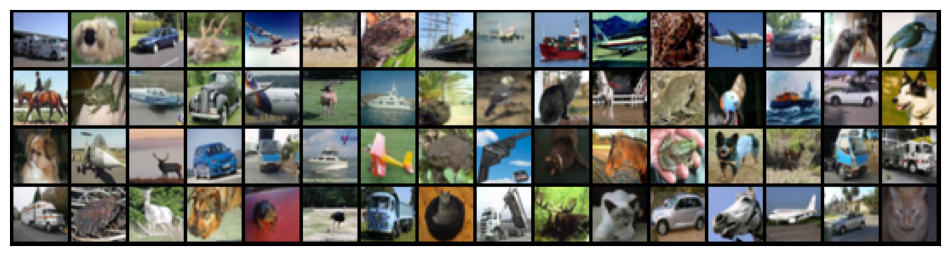

In [83]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

![Image](https://miro.medium.com/v2/resize:fit:640/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

Try to implement a convolution operation on 1 channel image with a 3x3 kernel.

In [84]:
def apply_kernel(image, kernel):
  ri, ci = image.shape        # image dimensions
  rk, ck = kernel.shape       # kernel dimensions
  ro, co = ri-rk+1, ci-ck+1   # output dimensions
  output = torch.zeros([ro, co])
  for i in range(ro):
    for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [85]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])

For multi-channel images, a different kernel is applied to each channels, and the outs are added together pixel-wise


The `Conv2d` layer transforms a 3-channel image to a 16-channel feature map, and the `MaxPool2d` layer halves the height and width. The *feature map* gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

![Image](https://i.imgur.com/KKtPOKE.png)

In [86]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch              # Extract images and labels from the batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate the cross-entropy loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch                # Extract images and labels from the batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        # Extract losses and accuracies from the validation outputs
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accs = [x["val_acc"] for x in outputs]
        
        # Combine losses and accuracies
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, epochs, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [87]:
# class Cifar10CnnModel(ImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

#             nn.Flatten(), 
#             nn.Linear(256*4*4, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10))
        
#     def forward(self, xb):
#         return self.network(xb)

In [88]:
### Add nn.BatchNorm2d() to after nn.Conv2d() and add nn.Dropout() ###
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add batch normalization
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add batch normalization
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout regularization
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout regularization
            nn.Linear(512, 10)
        )
    
    def forward(self, xb):
        return self.network(xb)


The comments explain the purpose of each part of the model architecture:

* **`nn.Conv2d`**: Performs a 2D convolution operation on the input. The specified parameters determine the number of input and output channels, kernel size, stride, and padding.
* [**`nn.ReLU`**](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html): Applies the Rectified Linear Unit (ReLU) activation function element-wise.
* **`nn.MaxPool2d`**: Performs 2D max pooling, reducing the spatial dimensions of the input tensor while preserving the number of channels.
* **`nn.Flatten`**: Flattens the input tensor into a 1D tensor, preparing it for the fully connected layers.
* **`nn.Linear`**: Applies a linear transformation to the input tensor, transforming it to the specified output size.
* [**`nn.BatchNorm2d`**](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html): Batch Norm is a normalization technique done between the layers of a Neural Network instead of in the raw data. It is done along mini-batches instead of the full data set. It serves to speed up training and use higher learning rates, making learning easier.
* [**`nn.Dropout`**](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html): During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.

The architecture consists of convolutional layers followed by ReLU activations and max pooling operations, which help extract features from the input image. After the convolutional layers, the tensor is flattened and passed through fully connected layers (linear transformations with ReLU activations) to generate the final output.

The architecture is designed for the CIFAR-10 dataset, which has input images of size 3x32x32 (3 channels, 32x32 pixels). The final fully connected layer has 10 units, corresponding to the 10 classes in the CIFAR-10 dataset.

In [89]:
model = Cifar10CnnModel()
print(model)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

In [90]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 32, 32])
out.shape: torch.Size([64, 10])
out[0]: tensor([ 0.2543, -0.3711,  0.2107, -0.3434,  0.0385,  0.1782,  0.0600,  0.1196,
        -0.1581,  0.1332], grad_fn=<SelectBackward0>)


In [91]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return the CUDA device if available
    else:
        return torch.device('cpu')  # Return the CPU device if CUDA is not available

def to_device(data, device):
    """Move tensor(s) to the chosen device"""
    if isinstance(data, (list, tuple)):
        # If the data is a list or tuple, recursively move each element to the device
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # Move the tensor to the device

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl  # Store the original dataloader
        self.device = device  # Store the device to which the data will be moved

    def __iter__(self):
        """Yield a batch of data after moving it to the device"""
        for b in self.dl:
            yield to_device(b, self.device)  # Yield a batch of data moved to the device

    def __len__(self):
        """Number of batches"""
        return len(self.dl)  # Return the number of batches in the original dataloader

In [92]:
device = get_default_device()
device

device(type='cuda')

In [93]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [94]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [95]:
model = to_device(Cifar10CnnModel(), device)
evaluate(model, val_dl)

{'val_loss': 2.302908182144165, 'val_acc': 0.0986328125}

In [96]:
num_epochs = 40
opt_func = torch.optim.Adam
lr = 0.001

In [97]:
history = fit(num_epochs, 
              lr, 
              model, 
              train_dl, 
              val_dl, 
              opt_func)

Epoch [1/40], train_loss: 1.4118, val_loss: 1.1509, val_acc: 0.5940
Epoch [2/40], train_loss: 0.9496, val_loss: 0.9208, val_acc: 0.6748
Epoch [3/40], train_loss: 0.7544, val_loss: 0.8587, val_acc: 0.7061
Epoch [4/40], train_loss: 0.6348, val_loss: 0.6089, val_acc: 0.7935
Epoch [5/40], train_loss: 0.5337, val_loss: 0.7469, val_acc: 0.7568
Epoch [6/40], train_loss: 0.4524, val_loss: 0.5752, val_acc: 0.8052
Epoch [7/40], train_loss: 0.3874, val_loss: 0.5697, val_acc: 0.8120
Epoch [8/40], train_loss: 0.3259, val_loss: 0.5571, val_acc: 0.8250
Epoch [9/40], train_loss: 0.2707, val_loss: 0.5764, val_acc: 0.8323
Epoch [10/40], train_loss: 0.2297, val_loss: 0.5874, val_acc: 0.8313
Epoch [11/40], train_loss: 0.1914, val_loss: 0.5702, val_acc: 0.8364
Epoch [12/40], train_loss: 0.1629, val_loss: 0.5509, val_acc: 0.8479
Epoch [13/40], train_loss: 0.1392, val_loss: 0.5792, val_acc: 0.8379
Epoch [14/40], train_loss: 0.1190, val_loss: 0.5799, val_acc: 0.8545
Epoch [15/40], train_loss: 0.1009, val_loss

Create helper function for plotting `Accuracy vs No. of epochs` and `Loss vs No. of epochs`

In [107]:
def plot_accuracies(history):
  val_acc = [x["val_acc"] for x in history]
  plt.plot(val_acc, "-x")
  plt.axhline(y=0.75, color="r", linestyle="--")  # Add a horizontal line at y = 0.75
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy vs No. of epochs")
  
def plot_losses(history):
  train_losses = [x.get("train_loss") for x in history]
  val_losses = [x["val_loss"] for x in history]
  plt.plot(train_losses, "-bx")
  plt.plot(val_losses, "-rx")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(["Training", "Validation"])
  plt.title("Loss vs No. of epochs");

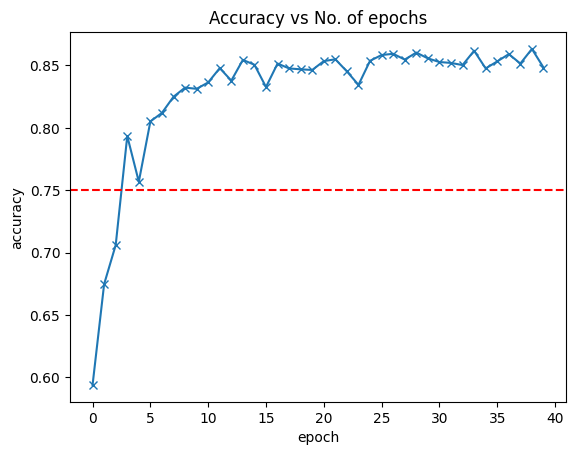

In [108]:
plot_accuracies(history)

The model reaches an accuracy of around 75% by looking at the graph, the result show that model not achieve an accuracy higher than 80% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between images and labels more accurately.
1. Adding more convolutional layers to our model.
2. Increasing the no. of channels in each convolutional layer.
3. Using regularization techniques. 

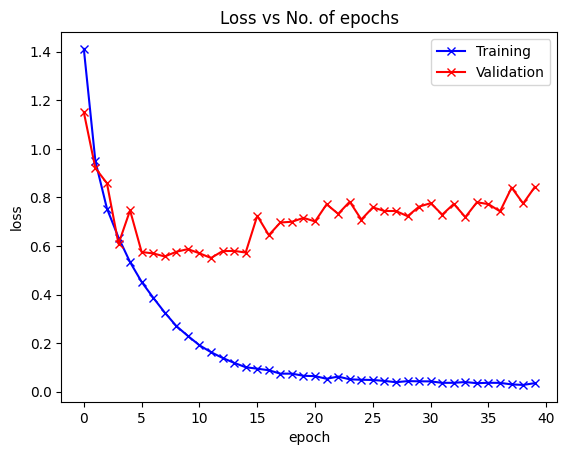

In [109]:
plot_losses(history=history)

Initially, both training and validation losses seem to decrease overtime. However, if you train the model for long time enough.
* The training loss continues to decrease.
* !!! **But validation loss stop decreasing, and even start to increase after a certain point.**

![Image](https://i.stack.imgur.com/1QU0m.png)

**Overfitting** refers to a situation in machine learning where a model performs well on the training data but fails to generalize to new, unseen data. In other words, the model becomes too specific to the training data and learns to memorize the training examples rather than capturing the underlying patterns and relationships.

> To avoid overfitting, consider the following strategies:
> 1. **Increase the training data**: Obtaining more diverse and representative training data can help the model learn better generalizations and reduce overfitting.
> 2. **Use data augmentation**: Augmenting the training data by applying random transformations (e.g., rotations, translations, flips) can increase the effective size of the training set and improve generalization.
> 3. **Regularization techniques:** Using regularization techniques like batch normalization & dropout.
> 4. **Early stopping:** Monitor the model's performance on a validation set during training and stop the training process when the performance starts to degrade. This prevents the model from over-optimizing on the training data.

## Testing with individual images

Creating a test dataset using the `ImageFolder` class.

In [110]:
test_dataset = ImageFolder(data_dir + "/test", transform=ToTensor())

In [111]:
def predict_image(img: torch.Tensor, model, dataset):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device=device)
    # Get predictions from the model
    yb = model(xb)
    # Calculate probabilities using softmax
    probabilities = torch.softmax(yb, dim=1)
    # Get the predicted class index
    _, predicted_idx = torch.max(probabilities, dim=1)
    # Retrieve the class label
    predicted_label = dataset.classes[predicted_idx.item()]
    # Get the confidence percentage
    confidence_percent = torch.max(probabilities) * 100

    return predicted_label, confidence_percent.item()

Label:  automobile | Predicted: ('automobile', 99.99968719482422)


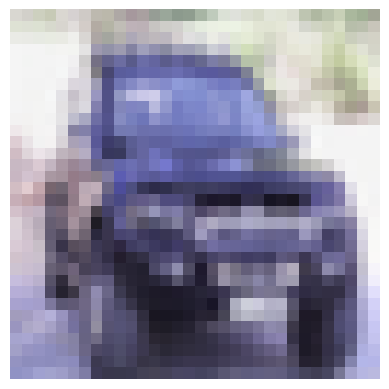

In [112]:
img, label = test_dataset[1001]
plt.imshow(img.permute(1, 2, 0)) # permute function change H x M x C
plt.axis('off')
print("Label: ", dataset.classes[label], "| Predicted:", predict_image(img=img, model=model, dataset=test_dataset))

In [113]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.9214350581169128, 'val_acc': 0.8447389006614685}

In [202]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def calculate_confusion_matrix(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = to_device(inputs.unsqueeze(0), device=device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_predictions.append(predicted.item())
            all_targets.append(targets)
    
    # Convert all_targets to a NumPy array
    all_targets = np.array(all_targets)
    print(len(all_predictions), len(all_targets))

    confusion_mat = confusion_matrix(all_targets, all_predictions)
    class_report = classification_report(y_true=all_targets, y_pred=all_predictions)

    return confusion_mat, class_report

In [203]:
confusion_mat, class_report = calculate_confusion_matrix(model=model, dataloader=test_dataset, device=device)

10000 10000


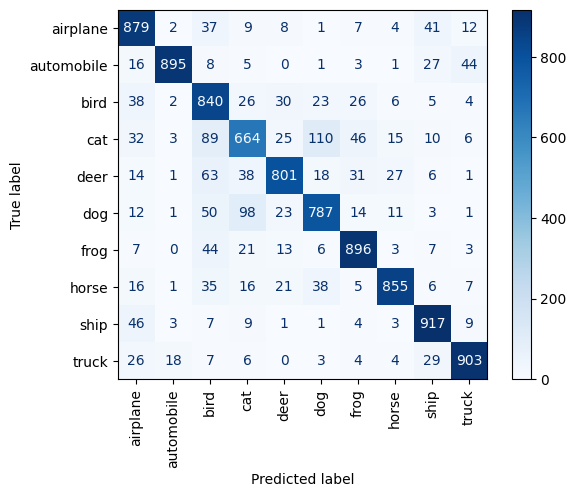

In [204]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [205]:
print(class_report)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1000
           1       0.97      0.90      0.93      1000
           2       0.71      0.84      0.77      1000
           3       0.74      0.66      0.70      1000
           4       0.87      0.80      0.83      1000
           5       0.80      0.79      0.79      1000
           6       0.86      0.90      0.88      1000
           7       0.92      0.85      0.89      1000
           8       0.87      0.92      0.89      1000
           9       0.91      0.90      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



## Saving and loading the model

We can save model and reuse the model later and avoid retraining from scratch. Here's how to save the model.

In [182]:
torch.save(model.state_dict(), "cifar10-cnn.pth")

The `.state_dict` method returns an `OrderedDice` containing all the weight and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [183]:
model2 = to_device(Cifar10CnnModel(), device=device)

In [184]:
model_path = "cifar10-cnn.pth"
model2.load_state_dict(state_dict=torch.load(model_path), strict=False)

<All keys matched successfully>

In [185]:
evaluate(model=model2, val_loader=test_loader)

{'val_loss': 0.9214350581169128, 'val_acc': 0.8447389006614685}

In [207]:
!pipreqs --force

INFO: Successfully saved requirements file in c:\image_classification_with_pytorch\requirements.txt
